In [15]:
import warnings

In [16]:
warnings.filterwarnings("ignore")

#### Import required models

In [17]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

#### Load the dataset

In [18]:
data = pd.read_csv("../NullValueHandled/KandyHandledNullValues.csv", index_col=0, parse_dates=True)

In [19]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000176
2019-01-02,2019-01-03,0.000092
2019-01-03,2019-01-04,0.000134
2019-01-04,2019-01-05,0.000191
2019-01-05,2019-01-06,0.000122


#### Do Not consider Next Date for Single Variate Models

In [6]:
kandy_data = data[["HCHO reading"]]
kandy_data.head()  

,HCHO reading
Current Date,
2019-01-01,0.000176
2019-01-02,0.000092
2019-01-03,0.000134
2019-01-04,0.000191
2019-01-05,0.000122


In [7]:
kandy_data.shape 

(1826, 1)

In [8]:
X = kandy_data.values

#### It shows there is a small seasonality in Kandy data

<Axes: xlabel='Current Date'>

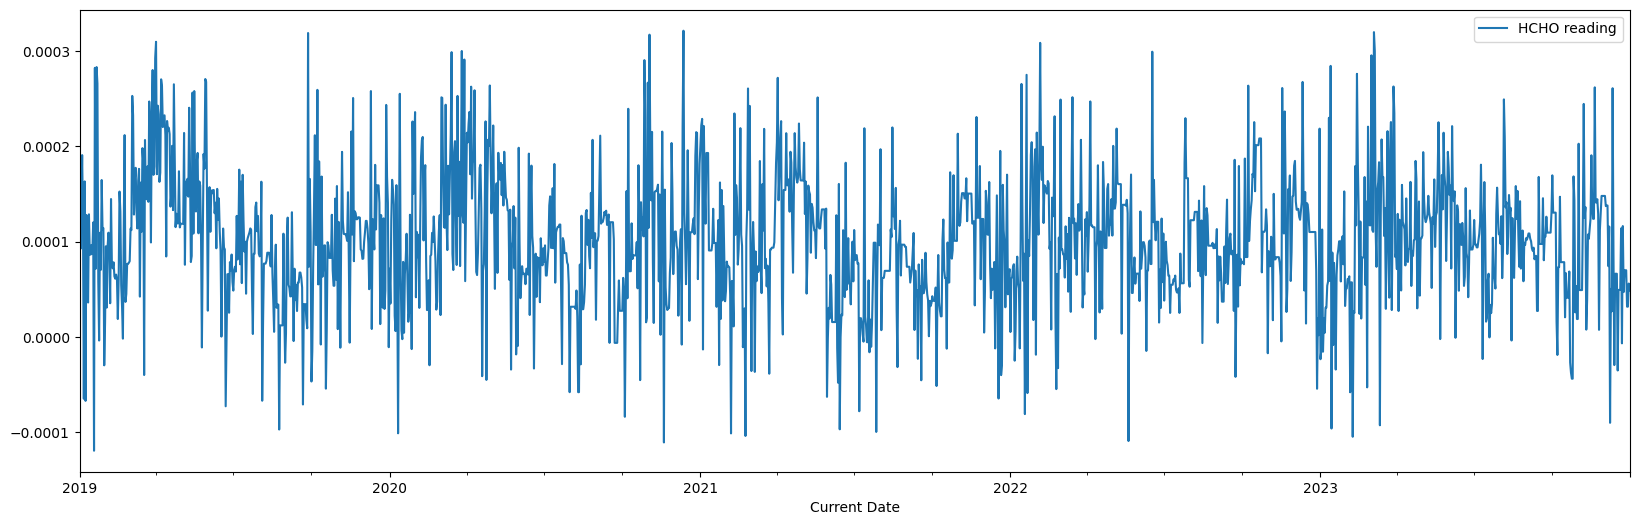

In [9]:
kandy_data.plot(figsize=(20, 6)) 

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
test_kandy = adfuller(kandy_data["HCHO reading"], autolag="AIC")

#### Check ADF and P Values

In [12]:
print("ADF value : ", test_kandy[0])
print("P value: ", test_kandy[1])
print("Num of Lags :", test_kandy[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_kandy[3])
for key, val in test_kandy[4].items():
    print("\t", key, ": ", val)

ADF value :  -6.900604814060024
P value:  1.2849822851718776e-09
Num of Lags : 17
Num of Observations used for ADF Regression and Critical Calculation : 1808
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


#### This P value has a very low score. It shows that values are ranging 
#### in a low range. Therefore, it is not required to use differencing techniques

### Auto correlation and correlation plot for Kandy City

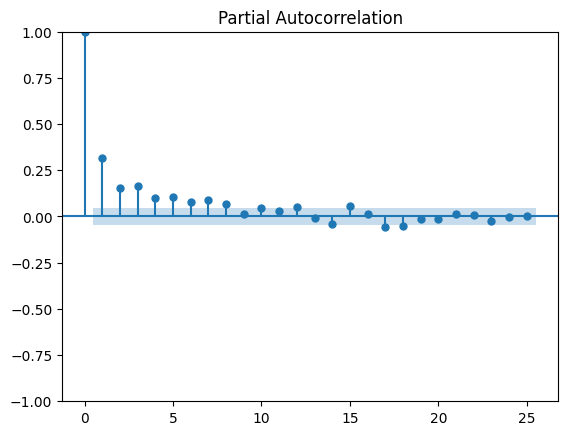

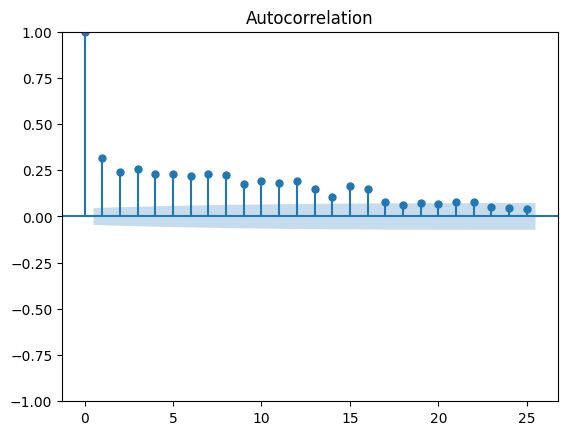

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(kandy_data["HCHO reading"], lags=25)
acf = plot_acf(kandy_data["HCHO reading"], lags=25)  

#### There is a small seasonality in kandy data due to majority of spikes are out of the boundary in the Auto Correlation Plot.

### Kandy with LSTM

In [34]:
data = pd.read_csv("../NullValueHandled/KandyHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [35]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000176
1   2019-01-02      0.000092
2   2019-01-03      0.000134
3   2019-01-04      0.000191
4   2019-01-05      0.000122


#### Train the model with LSTM model

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5 
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 33s 293ms/step - loss: 1.0545 - mean_squared_error: 1.0545 - val_loss: 0.6084 - val_mean_squared_error: 0.6084
Epoch 2/100
37/37 [==============================] - 5s 127ms/step - loss: 0.9604 - mean_squared_error: 0.9604 - val_loss: 0.5792 - val_mean_squared_error: 0.5792
Epoch 3/100
37/37 [==============================] - 5s 127ms/step - loss: 0.9334 - mean_squared_error: 0.9334 - val_loss: 0.5748 - val_mean_squared_error: 0.5748
Epoch 4/100
37/37 [==============================] - 5s 135ms/step - loss: 0.9388 - mean_squared_error: 0.9388 - val_loss: 0.6283 - val_mean_squared_error: 0.6283
Epoch 5/100
37/37 [==============================] - 5s 129ms/step - loss: 0.9277 - mean_squared_error: 0.9277 - val_loss: 0.6005 - val_mean_squared_error: 0.6005
Epoch 6/100
37/37 [==============================] - 5s 130ms/step - loss: 0.9136 - mean_squared_error: 0.9136 - val_loss: 0.5668 - val_mean_squared_error: 0.5668
Epoch 7/100
37/37 [==

37/37 [==============================] - 5s 138ms/step - loss: 0.8111 - mean_squared_error: 0.8111 - val_loss: 0.6028 - val_mean_squared_error: 0.6028
Epoch 52/100
37/37 [==============================] - 5s 135ms/step - loss: 0.8187 - mean_squared_error: 0.8187 - val_loss: 0.6131 - val_mean_squared_error: 0.6131
Epoch 53/100
37/37 [==============================] - 5s 136ms/step - loss: 0.8116 - mean_squared_error: 0.8116 - val_loss: 0.7578 - val_mean_squared_error: 0.7578
Epoch 54/100
37/37 [==============================] - 5s 134ms/step - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.5975 - val_mean_squared_error: 0.5975
Epoch 55/100
37/37 [==============================] - 5s 129ms/step - loss: 0.8119 - mean_squared_error: 0.8119 - val_loss: 0.6315 - val_mean_squared_error: 0.6315
Epoch 56/100
37/37 [==============================] - 5s 131ms/step - loss: 0.8192 - mean_squared_error: 0.8192 - val_loss: 0.6526 - val_mean_squared_error: 0.6526
Epoch 57/100
37/37 [=========

#### It shows that it has caught the seasonal variation pattern for the Kandy  Dataset.

12/12 [==============================] - 7s 34ms/step


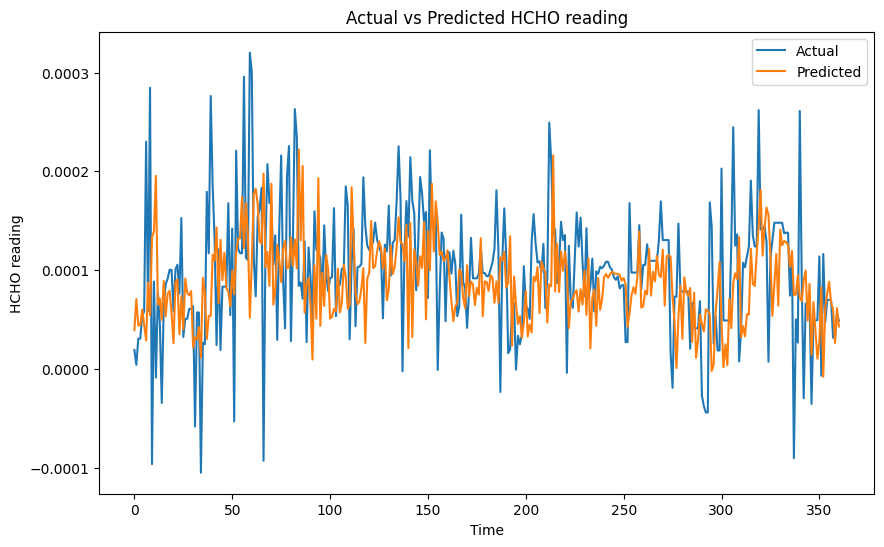

In [37]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [38]:
predictions.shape 

(361, 1)

#### The below plot shows even for the training set, it performs well.

46/46 [==============================] - 2s 37ms/step


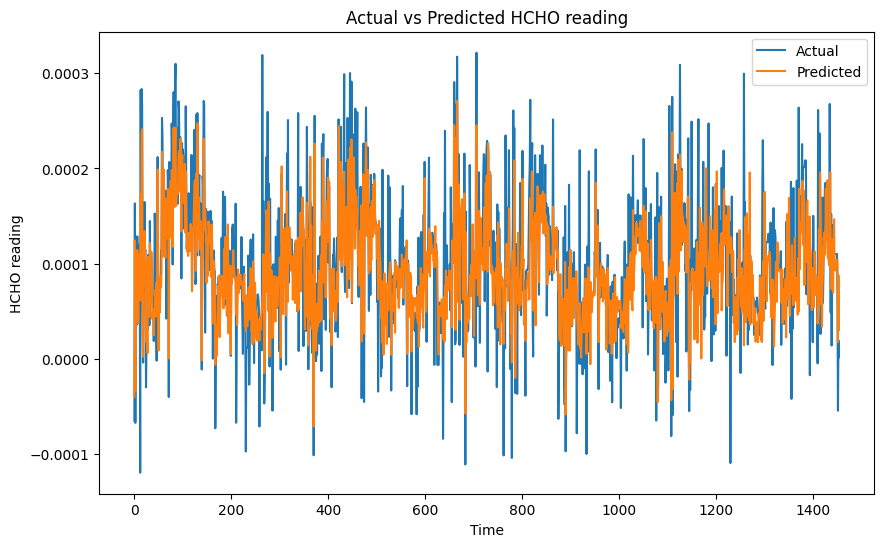

In [39]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### Do the forecasting based on the testing data

46/46 [==============================] - 2s 35ms/step


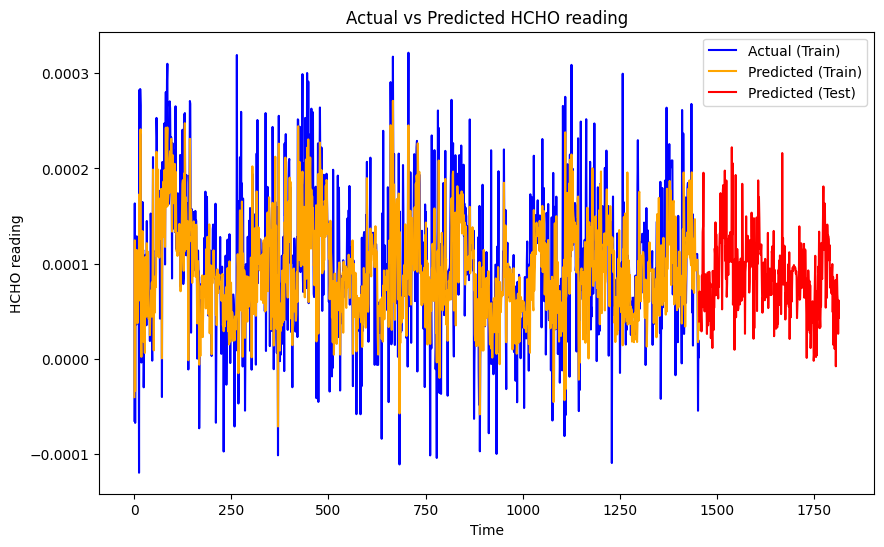

In [40]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### This model predicts well compared to other single variate models.It has a better r2, mse and mae values.

In [41]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.5181295102849051
Mean Absolute Error (MAE): 3.419645889366831e-05
Mean Squared Error (MSE): 2.2988523526856107e-09
Root Mean Squared Error (RMSE): 4.7946348689817984e-05
Median Absolute Error: 2.4984728885118213e-05
Explained Variance Score: 0.5346444065516949


### FB prophet Model

12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1] done processing


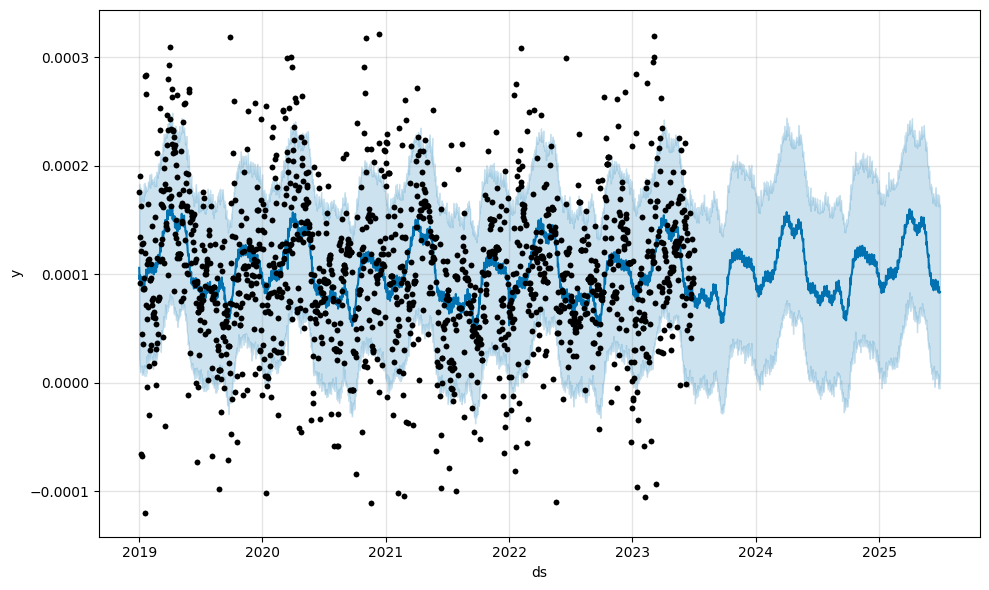

In [12]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/KandyHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds']) 

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.9 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=730)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

#### It does not catch a perfect seasonality like in Colombo predictions, How ever it has given a similar seasonality

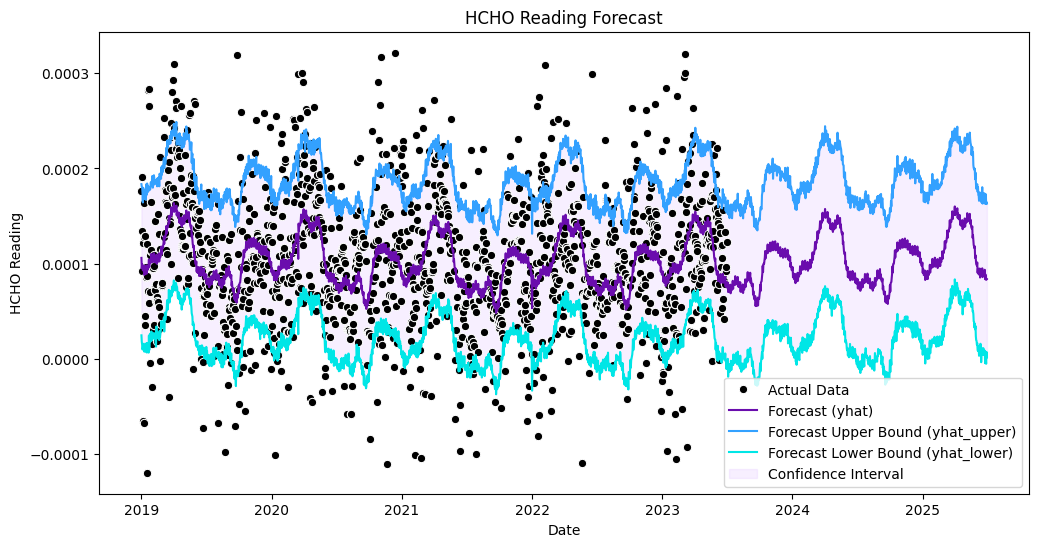

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

#### The below plot shows the trend of HCHO predictions 

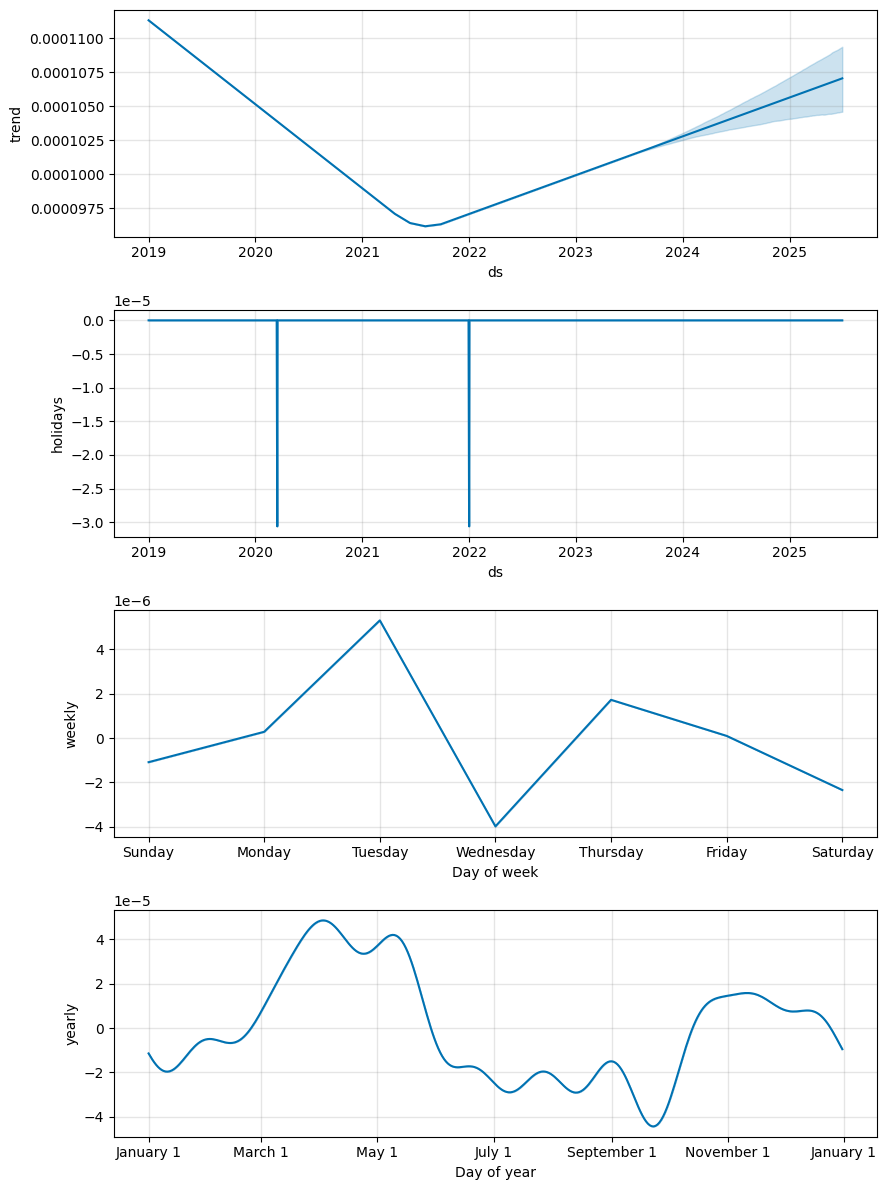

In [14]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

### Multi Variate Model 

In [13]:
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

#### get the information of the dataset

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   int64  
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   float64
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   float64
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

#### View all rows and columns

In [15]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Head of all the data

In [16]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000176,Kandy Proper,7.29,80.63,500,0.09,71.096,79.592,65.354,111701,28.53,3915.21,52.76,0.033072,0.000012,0.116477,0,0,Before,Before
1,2019-01-02,0.000092,Kandy Proper,7.29,80.63,500,0.01,70.124,78.764,63.716,111701,28.53,3915.21,52.76,0.032599,0.000013,0.116477,0,0,Before,Before
2,2019-01-03,0.000134,Kandy Proper,7.29,80.63,500,0.02,69.728,79.448,62.240,111701,28.53,3915.21,52.76,0.031031,0.000016,0.116477,0,0,Before,Before
3,2019-01-04,0.000191,Kandy Proper,7.29,80.63,500,0.00,69.224,79.610,61.214,111701,28.53,3915.21,52.76,0.030439,0.000010,0.116477,0,0,Before,Before
4,2019-01-05,0.000122,Kandy Proper,7.29,80.63,500,0.04,72.068,82.526,64.040,111701,28.53,3915.21,52.76,0.031700,0.000014,0.116477,0,0,Before,Before


#### remove constant data

In [17]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [18]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)', 'Population', 'population_density'], inplace=True)

In [19]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000176,0.09,71.096,79.592,65.354,0.033072,0.000012,0.116477,0,0,Before,Before
1,2019-01-02,0.000092,0.01,70.124,78.764,63.716,0.032599,0.000013,0.116477,0,0,Before,Before
2,2019-01-03,0.000134,0.02,69.728,79.448,62.240,0.031031,0.000016,0.116477,0,0,Before,Before
3,2019-01-04,0.000191,0.00,69.224,79.610,61.214,0.030439,0.000010,0.116477,0,0,Before,Before
4,2019-01-05,0.000122,0.04,72.068,82.526,64.040,0.031700,0.000014,0.116477,0,0,Before,Before


#### Encode Categorical data

In [20]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [21]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000176,0.09,71.096,79.592,65.354,0.033072,0.000012,0.116477,0,0,1,1
1,2019-01-02,0.000092,0.01,70.124,78.764,63.716,0.032599,0.000013,0.116477,0,0,1,1
2,2019-01-03,0.000134,0.02,69.728,79.448,62.240,0.031031,0.000016,0.116477,0,0,1,1
3,2019-01-04,0.000191,0.00,69.224,79.610,61.214,0.030439,0.000010,0.116477,0,0,1,1
4,2019-01-05,0.000122,0.04,72.068,82.526,64.040,0.031700,0.000014,0.116477,0,0,1,1


#### Check correlations

In [22]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr

,HCHO reading
HCHO reading,1.000000
PRCP,-0.023929
TAVG,0.162298
TMAX,0.248444
TMIN,-0.044744
carbon_monoxide,0.186016
nitogen_dioxide,0.114099
ozone,-0.014814
new_covid_patients,-0.078542
total_covid_patients,-0.046318


In [23]:
corr.to_csv("../OtherData/KandyCorrelationData.csv")

In [24]:
data.shape

(1826, 13)

#### remove covid range status

In [25]:
data.drop(columns=["covid_range_status"], inplace=True)

#### Devide X and Y

In [26]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [27]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status
0,2019-01-01,0.09,71.096,79.592,65.354,0.033072,0.000012,0.116477,0,0,1
1,2019-01-02,0.01,70.124,78.764,63.716,0.032599,0.000013,0.116477,0,0,1
2,2019-01-03,0.02,69.728,79.448,62.240,0.031031,0.000016,0.116477,0,0,1
3,2019-01-04,0.00,69.224,79.610,61.214,0.030439,0.000010,0.116477,0,0,1
4,2019-01-05,0.04,72.068,82.526,64.040,0.031700,0.000014,0.116477,0,0,1


#### Select features based on Correlations

In [28]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.023929
TAVG                    0.162298
TMAX                    0.248444
TMIN                   -0.044744
carbon_monoxide         0.186016
nitogen_dioxide         0.114099
ozone                  -0.014814
new_covid_patients     -0.078542
total_covid_patients   -0.046318
lockdown_status        -0.028364
Name: HCHO reading, dtype: float64

#### Plot the Correlation Matrix

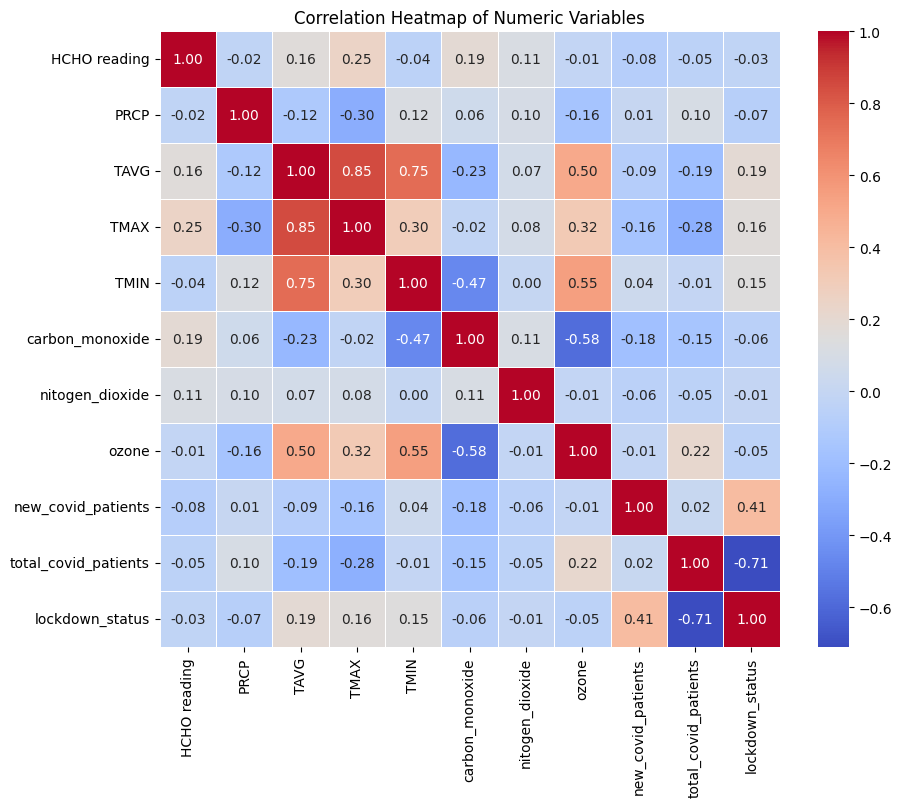

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is your DataFrame
correlation_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

#### Select high correlated column data

In [30]:
X = X[["Current Date", "carbon_monoxide", "nitogen_dioxide", "TMAX"]]
X.head() 

,Current Date,carbon_monoxide,nitogen_dioxide,TMAX
0,2019-01-01,0.033072,0.000012,79.592
1,2019-01-02,0.032599,0.000013,78.764
2,2019-01-03,0.031031,0.000016,79.448
3,2019-01-04,0.030439,0.000010,79.610
4,2019-01-05,0.031700,0.000014,82.526


In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current Date     1826 non-null   object 
 1   carbon_monoxide  1826 non-null   float64
 2   nitogen_dioxide  1826 non-null   float64
 3   TMAX             1826 non-null   float64
dtypes: float64(3), object(1)
memory usage: 57.2+ KB


#### Standardize, variable data

In [32]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide", "nitogen_dioxide", "TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   nitogen_dioxide  1826 non-null   float64
 2   TMAX             1826 non-null   float64
dtypes: float64(3)
memory usage: 57.1 KB


##### Standardize target variable

In [34]:
y = data['HCHO reading']

y.head()

0    0.000176
1    0.000092
2    0.000134
3    0.000191
4    0.000122
Name: HCHO reading, dtype: float64

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [36]:
X_scaled = X

#### Plot of the standerdized HCHO distribution data

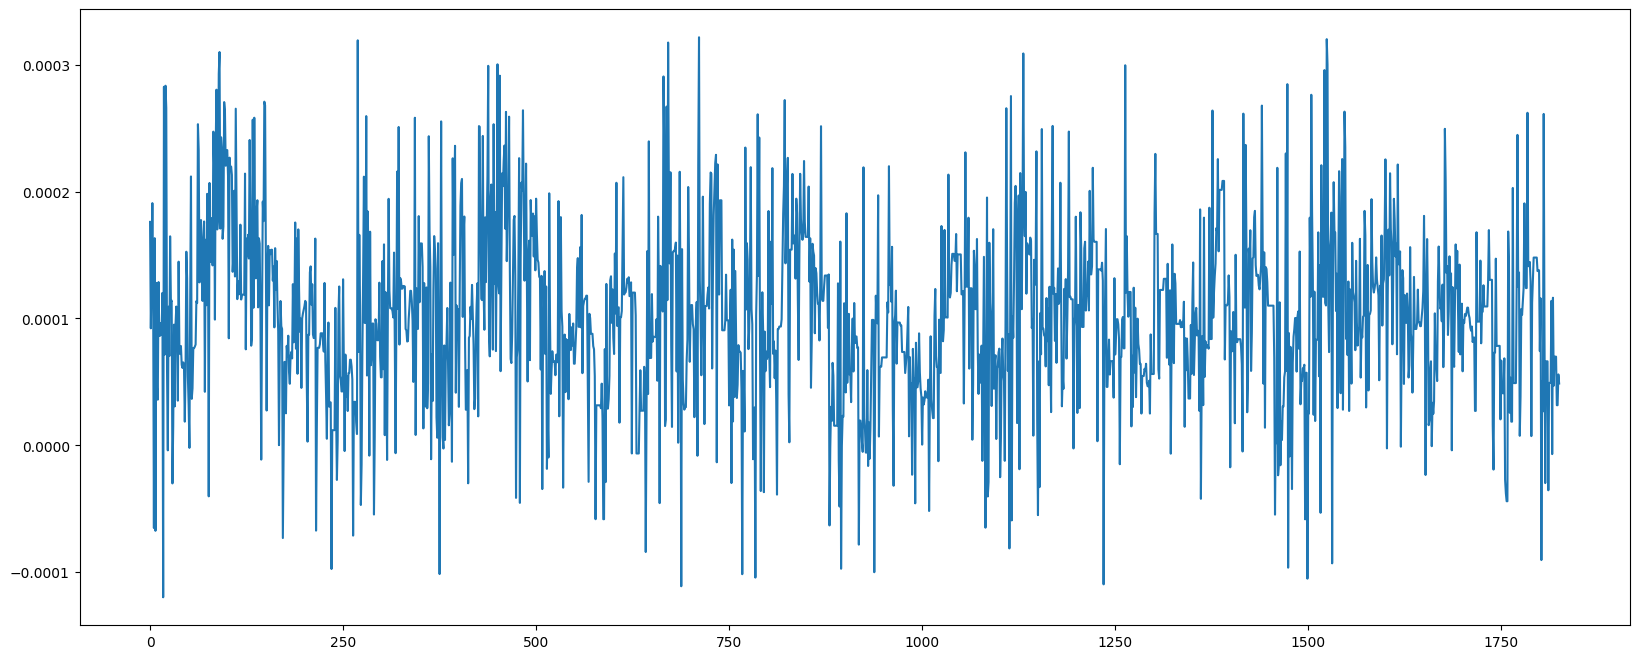

In [37]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [38]:
print(X_scaled.head())

              carbon_monoxide  nitogen_dioxide      TMAX
Current Date                                            
2019-01-01           0.776304        -0.183367 -1.318707
2019-01-02           0.692910        -0.056819 -1.513369
2019-01-03           0.416637         0.448063 -1.352561
2019-01-04           0.312332        -0.567635 -1.314475
2019-01-05           0.534479         0.077008 -0.628923


#### Apply multivariate time series model

In [109]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]


model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True, activation="relu"), input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    Bidirectional(LSTM(units=5)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
46/46 [==============================] - 10s 46ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 2/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 3/150
46/46 [==============================] - 0s 9ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 4/150
46/46 [==============================] - 0s 9ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 5/150
46/46 [==============================] - 0s 9ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 6/150
46/46 [==============================] - 0s 9ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 7/150
46/46 [============

46/46 [==============================] - 0s 10ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 102/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 103/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 104/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 105/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 106/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 107/150
46/46 [=========

##### The below plot shows, it does not predict well for multivariate LSTM model

12/12 [==============================] - 0s 4ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Test Loss: [0.02274596132338047, 0.02274596132338047]
12/12 [==============================] - 2s 3ms/step


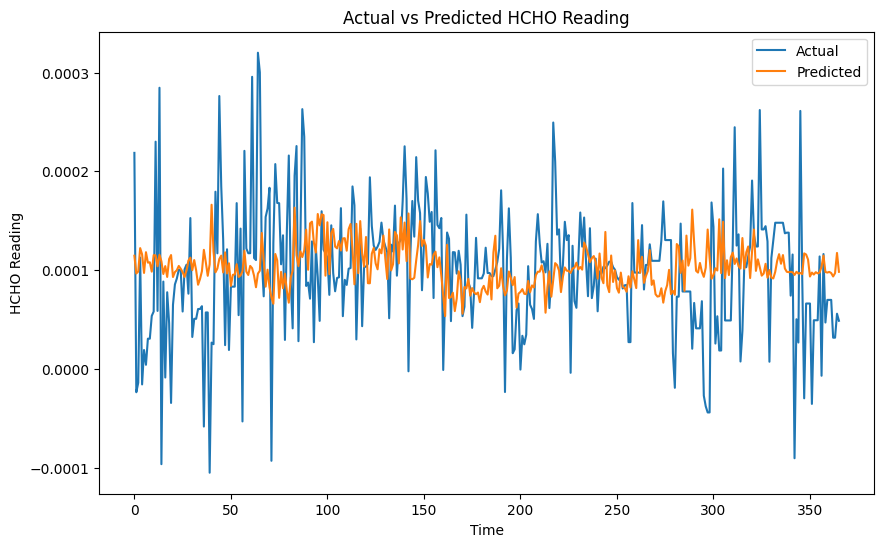

In [110]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

#### The below plot shows it does not even predict for the training dataset.

46/46 [==============================] - 0s 3ms/step


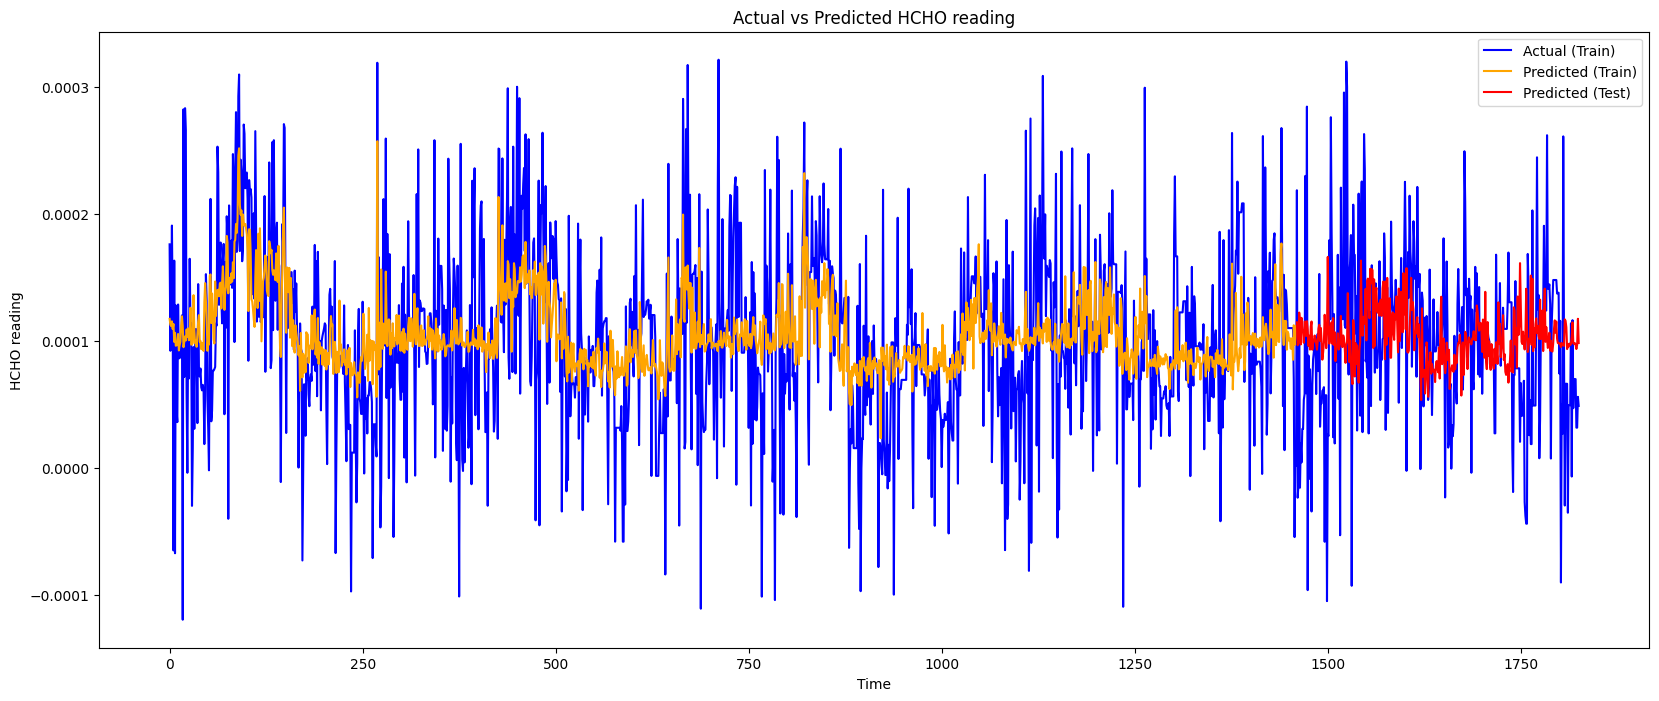

In [111]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### Since it has a negative R2 score, it shows that this model gives wrong predictions.

In [130]:
r2 = (r2_score(actual_test, predictions_test))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.05679029498421895
Mean Absolute Error (MAE): 5.042004426630236e-05
Mean Squared Error (MSE): 4.429226799817008e-09
Root Mean Squared Error (RMSE): 6.655243646792361e-05
Median Absolute Error: 3.9719315677331935e-05
Explained Variance Score: -0.05327906121776227


## Single Variate Time Series Models

### Single Variate AR Model

In [45]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load data
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_ar = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(5, 0, 0))  # AR model with p=1, d=0, q=0 (since it's AR)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]  # Forecasting 1 step ahead
    yhat_ar.append(predictions)

yhat_ar = pd.Series(yhat_ar, index=test.index)
ar_mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Print or store the results
print("ARIMA MSE:", ar_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [14:05<00:00,  2.31s/it]

ARIMA MSE: 3.8807309115695035e-09


##### This plot shows, it does not preict values in the correct range, but it has caught the seasonal pattern.

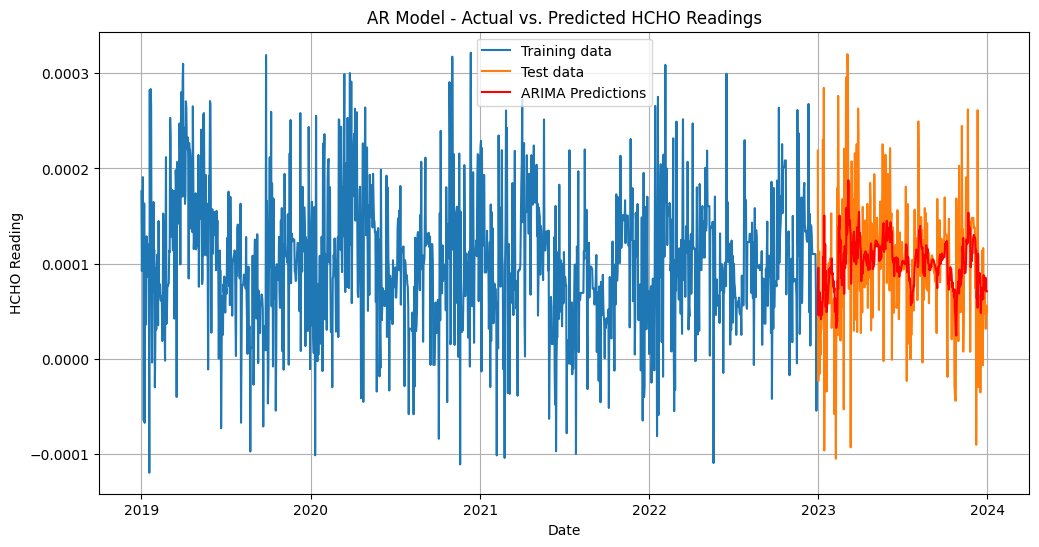

In [46]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('AR Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

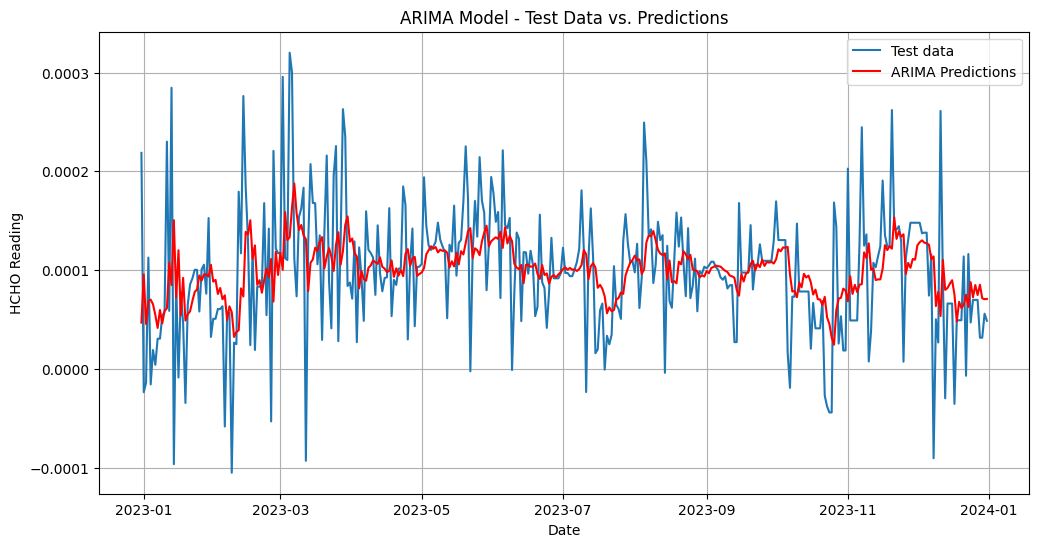

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

#### There is a very low R2 score for this model. However, since it predicts values by maintaining the seasonality,
#### it has a better mse and mae score.

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.154468128116001e-05
Mean Squared Error (MSE): 3.822010106791419e-09
R-squared (R2) Score: 0.08808842474364986
Root Mean Squared Error (RMSE): 6.182240780486813e-05
Median Absolute Error: 2.394854018911727e-05
Explained Variance Score: 0.08823259449949339


### ARMA model for Kandy

#### Use Auto Arema function to get the best seasonal parameters for the model

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load data
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example using auto_arima
model = auto_arima(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'TMAX', 'nitogen_dioxide']],
                   seasonal=True, m=12,  # assuming monthly seasonality
                   trace=True)  # to display the model selection process
model_fit = model.fit(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'TMAX', 'nitogen_dioxide']])

# Forecasting
forecast = model_fit.predict(n_periods=len(test), exogenous=test[['carbon_monoxide', 'TMAX', 'nitogen_dioxide']])

# Calculating MSE
sarima_mse = mean_squared_error(test['HCHO reading'], forecast)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-23928.598, Time=6.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-23829.297, Time=0.25 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23560.367, Time=3.61 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-23962.908, Time=6.88 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-22141.645, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-23908.601, Time=0.98 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-23779.336, Time=4.67 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-23964.911, Time=7.90 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-23778.314, Time=15.55 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-23896.869, Time=7.39 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-24062.974, Time=7.49 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24061.516, Time=5.33 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-24016.011, Time=14.11 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-23973.145, Tim

#### Train the ARMA model

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# load data
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_arma = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(2, 0, 3))  # ARMA model with p=1,d=0,  q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=2)[0]
    yhat_arma.append(predictions)

yhat_arma = pd.Series(yhat_arma, index=test.index)
arma_mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Print or store the results
print("ARIMA MSE:", arma_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [05:41<00:00,  1.07it/s]

ARIMA MSE: 3.822010106791419e-09


#### This model does catch the fluctuation ranges, even if the has caught the seasonality pattern

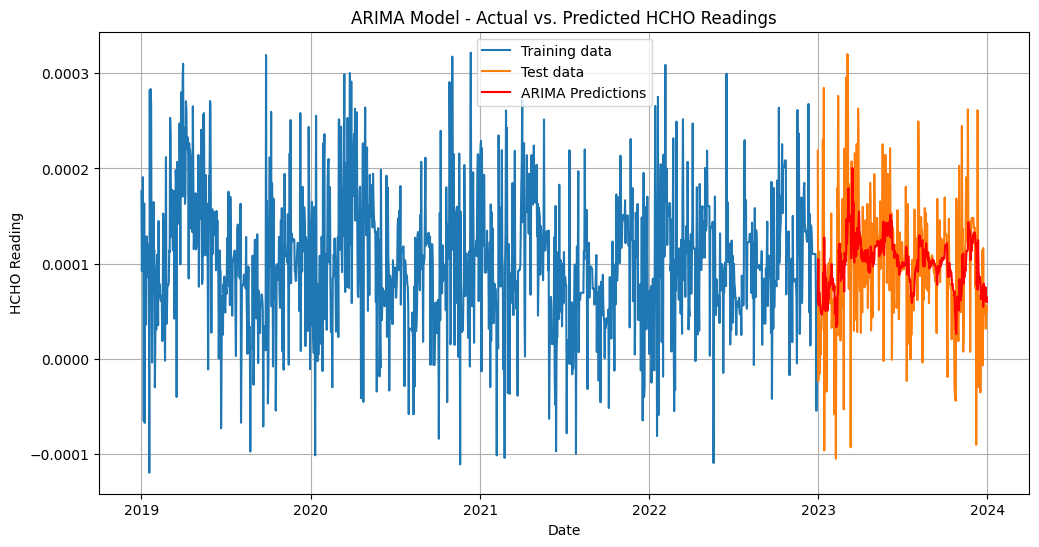

In [25]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

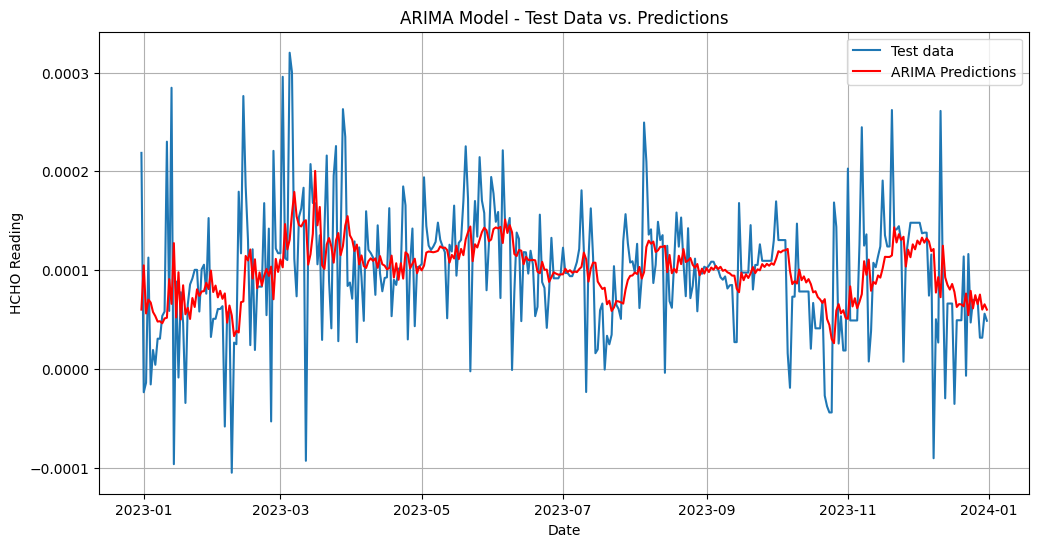

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

#### It has a low R2 Score, but it has better mse and mae values.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.154468128116001e-05
Mean Squared Error (MSE): 3.822010106791419e-09
R-squared (R2) Score: 0.08808842474364986
Root Mean Squared Error (RMSE): 6.182240780486813e-05
Median Absolute Error: 2.394854018911727e-05
Explained Variance Score: 0.08823259449949339


#### SARIMA model 

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example
yhat_sarima = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(2, 0, 3), seasonal_order=(0, 0, 2, 12))  # SARIMA model with p=1,d=0,q=1 and seasonal order (P,D,Q,s) = (1,0,1,12)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)  # Forecasting 10 steps ahead
    yhat_sarima.append(predictions[-1])  # Appending only the last value of the forecast

yhat_sarima = pd.Series(yhat_sarima, index=test.index)
sarima_mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [37:58<00:00,  6.22s/it]

SARIMA MSE: 4.143389175905366e-09


#### When the seasonal parameter is added, it has caught the fluctuation petter better than AR, ARMA in the HCHO testing data.

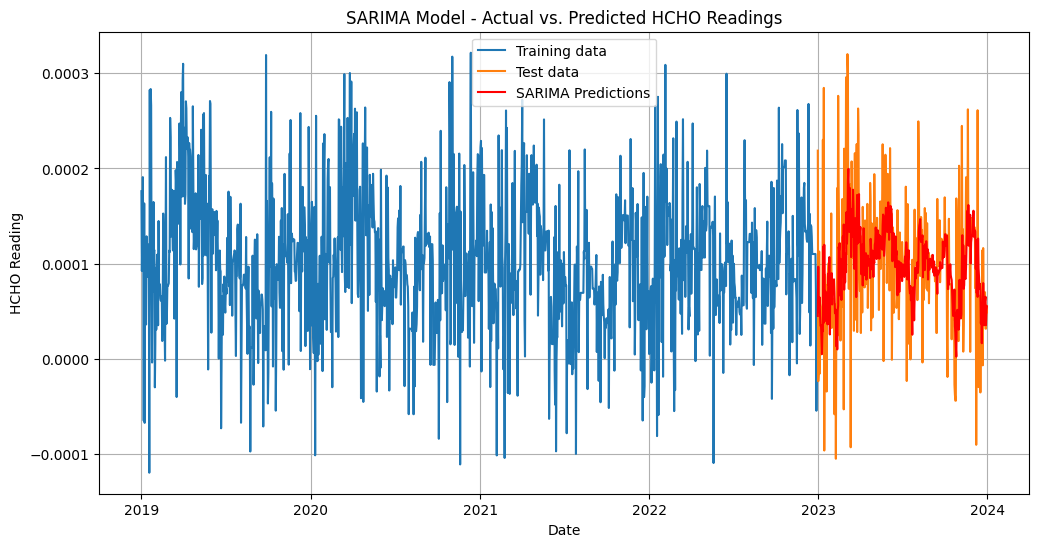

In [33]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True) 
plt.show()

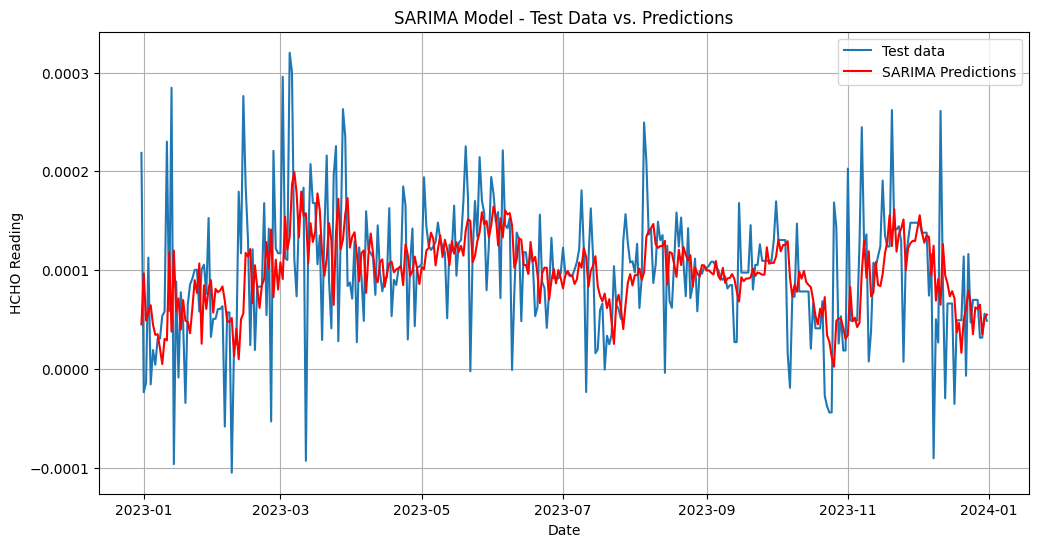

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

#### Even the pattern is recognised, it has a low R2 score

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.283256325009043e-05
Mean Squared Error (MSE): 4.143389175905366e-09
R-squared (R2) Score: 0.011409063627006666
Root Mean Squared Error (RMSE): 6.436916323757337e-05
Median Absolute Error: 2.2832639260791675e-05
Explained Variance Score: 0.011787483312777236


## Multi-variate models

#### BayesianRidge Model

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TMAX', 'carbon_monoxide', 'nitogen_dioxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TMAX', 'carbon_monoxide', 'nitogen_dioxide']].values
y_test = test['HCHO reading'].values


# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Bayesian Regression
bayesian_reg = BayesianRidge()

# Fit the model
bayesian_reg.fit(X_train_scaled, y_train_scaled)

# Predictions
y_train_pred = bayesian_reg.predict(X_train_scaled)
y_test_pred = bayesian_reg.predict(X_test_scaled)

# Inverse transform to get actual values
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_actual))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 6.459331197633902e-05
Test RMSE: 6.468030324109945e-05


#### The below plot shows that the bayesian Regression model does not perform well in finding the seasonality pattern

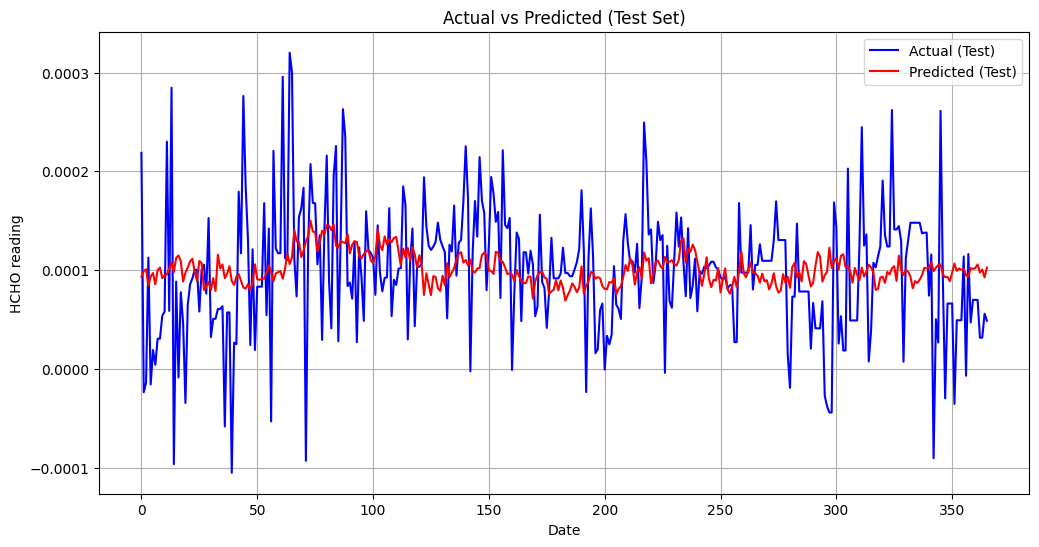

In [9]:
# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot([x for x in range(0, len(y_test))], y_test, label='Actual (Test)', color='blue')
plt.plot([x for x in range(0, len(y_test))], y_test_pred_actual, label='Predicted (Test)', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO reading') 
plt.legend()
plt.grid(True)
plt.show()

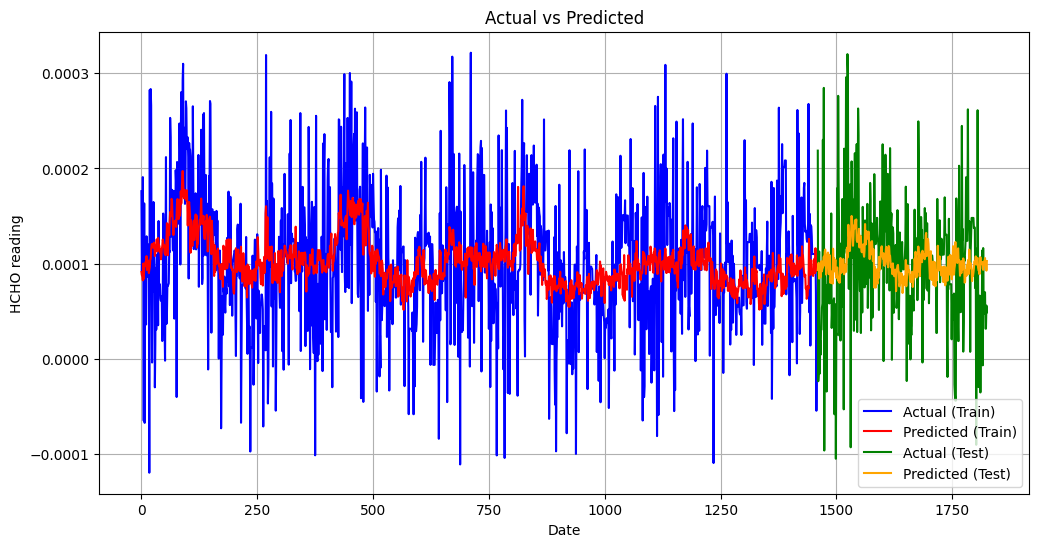

In [10]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for both training and test sets
plt.figure(figsize=(12, 6)) 
plt.plot(range(0, len(y_train)), y_train, label='Actual (Train)', color='blue')
plt.plot(range(0, len(y_train)), y_train_pred_actual, label='Predicted (Train)', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred_actual, label='Predicted (Test)', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Date') 
plt.ylabel('HCHO reading')
plt.legend()
plt.grid(True)
plt.show()

#### It has a very low R2 score compared to other regions data

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,  median_absolute_error, explained_variance_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_actual)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_actual)

# Calculate R2 score 
r2 = r2_score(y_test, y_test_pred_actual)

rmse = mean_squared_error(y_test, y_test_pred_actual, squared=False)

median_absolute = median_absolute_error(y_test, y_test_pred_actual) 
 
explained_variance = explained_variance_score(y_test, y_test_pred_actual)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.907026288221758e-05
Mean Squared Error (MSE): 4.183541627360579e-09
R-squared (R2) Score: 0.0018288992020449868
Root Mean Squared Error (RMSE): 6.468030324109945e-05
Median Absolute Error: 3.784257203123018e-05
Explained Variance Score: 0.0027195749708315287


### Random Forest Model

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TMAX', 'carbon_monoxide', 'nitogen_dioxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TMAX', 'carbon_monoxide', 'nitogen_dioxide']].values
y_test = test['HCHO reading'].values
# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Define the Random Forest model
random_forest_reg = RandomForestRegressor()

# Define the hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(random_forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best model
best_random_forest_reg = grid_search.best_estimator_

#### Do a Hyper parameterized optimazation for the Random forest model

In [13]:
# Predictions
y_train_pred = best_random_forest_reg.predict(X_train_scaled)
y_test_pred = best_random_forest_reg.predict(X_test_scaled)

# Inverse transform to get actual values
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_actual))

print("Best Parameters:", grid_search.best_params_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Train RMSE: 4.907347431457193e-05
Test RMSE: 6.872833992360422e-05


#### The below plot shows that, it does not perform well for Random Forest Regressor Model

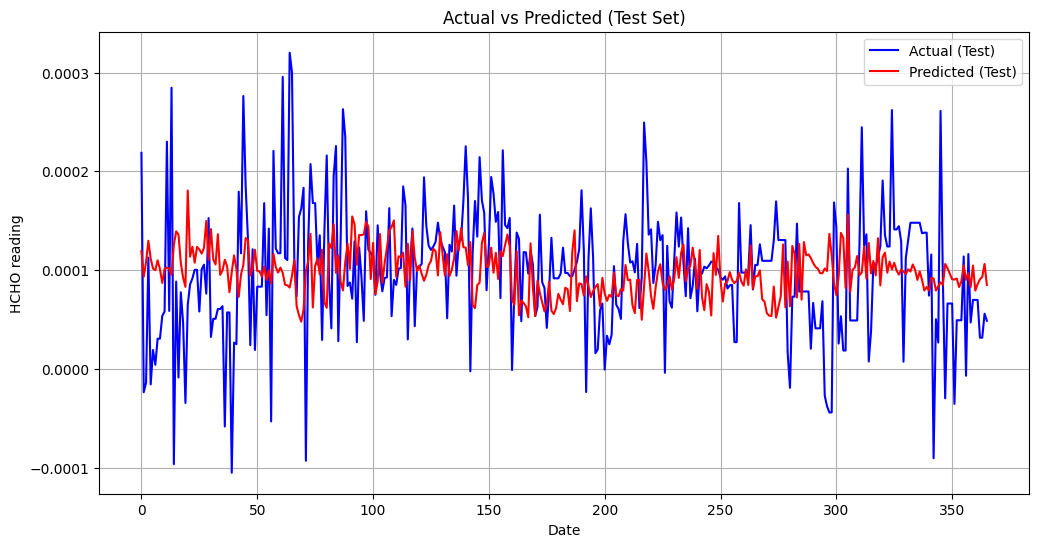

In [14]:
# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot([x for x in range(0, len(y_test))], y_test, label='Actual (Test)', color='blue')
plt.plot([x for x in range(0, len(y_test))], y_test_pred_actual, label='Predicted (Test)', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO reading') 
plt.legend()
plt.grid(True)
plt.show()

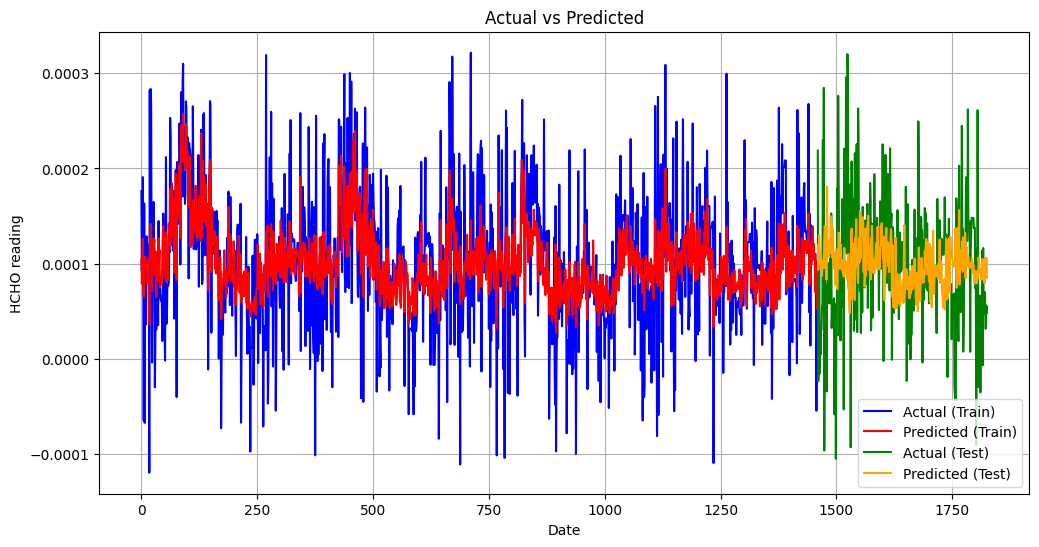

In [15]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for both training and test sets
plt.figure(figsize=(12, 6)) 
plt.plot(range(0, len(y_train)), y_train, label='Actual (Train)', color='blue')
plt.plot(range(0, len(y_train)), y_train_pred_actual, label='Predicted (Train)', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred_actual, label='Predicted (Test)', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Date') 
plt.ylabel('HCHO reading')
plt.legend()
plt.grid(True)
plt.show()

#### There is a minus R2Score for the Random Forest Regressor Model

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_actual)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_actual)

# Calculate R2 score 
r2 = r2_score(y_test, y_test_pred_actual)

rmse = mean_squared_error(y_test, y_test_pred_actual, squared=False)

median_absolute = median_absolute_error(y_test, y_test_pred_actual) 
 
explained_variance = explained_variance_score(y_test, y_test_pred_actual)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.25524934288282e-05
Mean Squared Error (MSE): 4.7235847086544894e-09
R-squared (R2) Score: -0.12702254891263665
Root Mean Squared Error (RMSE): 6.872833992360422e-05
Median Absolute Error: 4.142053154923041e-05
Explained Variance Score: -0.12686557962360312


### Multi Variate SARIMAX

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pmdarima import auto_arima

#### Load required data

In [21]:
# Load data
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'nitogen_dioxide': data["nitogen_dioxide"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

#### Train the SARIMAX model

In [22]:
from tqdm import tqdm
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Find the best parameters using auto_arima
# Fit the SARIMAX Model
exog_train = train[['carbon_monoxide', 'nitogen_dioxide', 'TMAX']]
endog_train = train['HCHO reading']

model = SARIMAX(endog_train, exog=exog_train, order=(2, 0, 3), seasonal_order=(0, 0, 2, 12))
model_fit = model.fit(disp=False)

# Forecast
yhat_sarima = []
for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(2, 0, 3), seasonal_order=(0, 0, 2, 12))  
    model_fit = model.fit()
    exog_test = test[['carbon_monoxide', 'nitogen_dioxide', 'TMAX']].iloc[t]
    predictions = model_fit.forecast(steps=1, exog=exog_test)  
    yhat_sarima.append(predictions[-1])

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [43:23<00:00,  7.11s/it]


#### The below plot shows SARIMA Multivariate model performs better than the other Multivariate models.

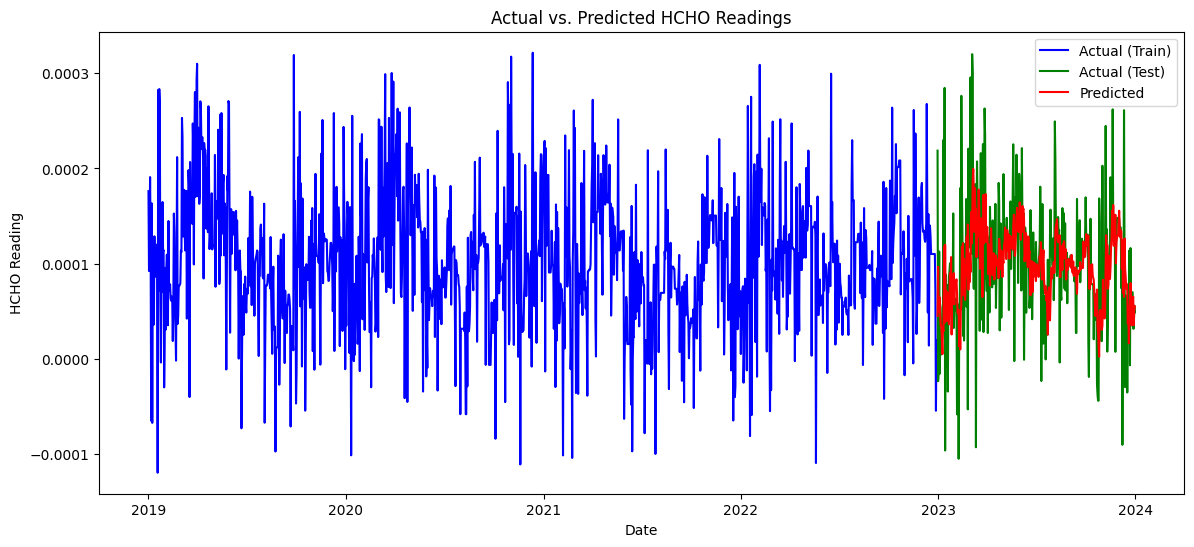

In [23]:
# Plotting
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train.index, train['HCHO reading'], label='Actual (Train)', color='blue')

# Plot testing data
plt.plot(test.index, test['HCHO reading'], label='Actual (Test)', color='green')

# Plot predicted values
plt.plot(test.index, yhat_sarima, label='Predicted', color='red')

plt.title('Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

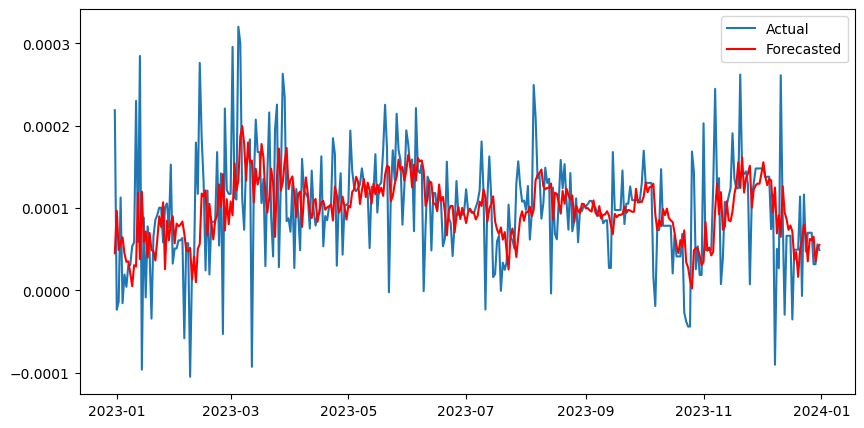

In [24]:
# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(test.index, test['HCHO reading'], label='Actual')
plt.plot(test.index, yhat_sarima, label='Forecasted', color='red')
plt.legend()
plt.show()

#### It shows there is a bit low R2 score. However, it has caught the seasonal pattern better than other models

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.283256325009043e-05
Mean Squared Error (MSE): 4.143389175905366e-09
R-squared (R2) Score: 0.011409063627006666
Root Mean Squared Error (RMSE): 6.436916323757337e-05
Median Absolute Error: 2.2832639260791675e-05
Explained Variance Score: 0.011787483312777236


#### Conclusion : As in most of the cities, the Single variate LSTM model performs better than other models.
#### Out of the trained Multivariate models, SARIMAX(SARIMA) model performs better than other models in finding the 
#### seasonality of the HCHO distribution levels.